In [1]:
# load the data
import os
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')
def mask_data(ds):
    var_list = [var for var in ds.data_vars]
    mask = (ds.lat<-60).broadcast_like(ds[var_list[0]])
    for var in ds.data_vars:  
        ds[var] = ds[var].where(~mask, drop=True)
    return ds

def nan_mask(ds,layer):
    if layer == 'ssm':
        layer='ESA CCI'
    elif layer == 'rzsm':
        layer='GLEAM'
    nan_mask = ds[layer].isnull()
    for var in ds.data_vars:  
        ds[var] = ds[var].where(~nan_mask,drop=True)
    return ds

root = '../plotdata'
ds_esa = xr.open_dataset(os.path.join(root,'ESACCI_00_23.nc'))
ds_smrfr = xr.open_dataset(os.path.join(root,'SMRFR_00_23.nc'))
ds_era = xr.open_dataset(os.path.join(root,'ERA5Land_00_23.nc'))
ds_gleam = xr.open_dataset(os.path.join(root,'GLEAM_00_22.nc'))

In [5]:
# preprocess the data
name = 'rzsm' #change the name to plot SSM/RZSM maps
if name=='ssm':
    ds = xr.combine_by_coords([ds_smrfr['sml1_p'],ds_era['ssm'],ds_gleam['SMsurf'],ds_esa['sm']])
    ds = ds.rename({'sml1_p':'SMRFR',
                    'ssm':'ERA5 Land',
                    'SMsurf':'GLEAM',
                    'sm':'ESA CCI'})
    
elif name=='rzsm':
    ds_smrfr['rzsm_smrfr'] = 0.05*ds_smrfr['sml1_p']+0.05*ds_smrfr['sml2_p']+0.2*ds_smrfr['sml3_p']+0.2*ds_smrfr['sml4_p']+0.5*ds_smrfr['sml5_p']
    ds = xr.combine_by_coords([ds_smrfr['rzsm_smrfr'],ds_era['rzsm'],ds_gleam['SMroot']])
    ds = ds.rename({'rzsm_smrfr':'SMRFR',
                    'rzsm':'ERA5 Land',
                    'SMroot':'GLEAM'})
ds = mask_data(ds)
ds = nan_mask(ds,layer=name)

SMRFR-ERA5 Land 0-1
SMRFR-GLEAM 0-2
SMRFR-ESA CCI 0-3
kdeplot ERA5 Land-SMRFR 1-0
ERA5 Land-GLEAM 1-2
ERA5 Land-ESA CCI 1-3
kdeplot GLEAM-SMRFR 2-0
kdeplot GLEAM-ERA5 Land 2-1
GLEAM-ESA CCI 2-3
kdeplot ESA CCI-SMRFR 3-0
kdeplot ESA CCI-ERA5 Land 3-1
kdeplot ESA CCI-GLEAM 3-2
121 seconds


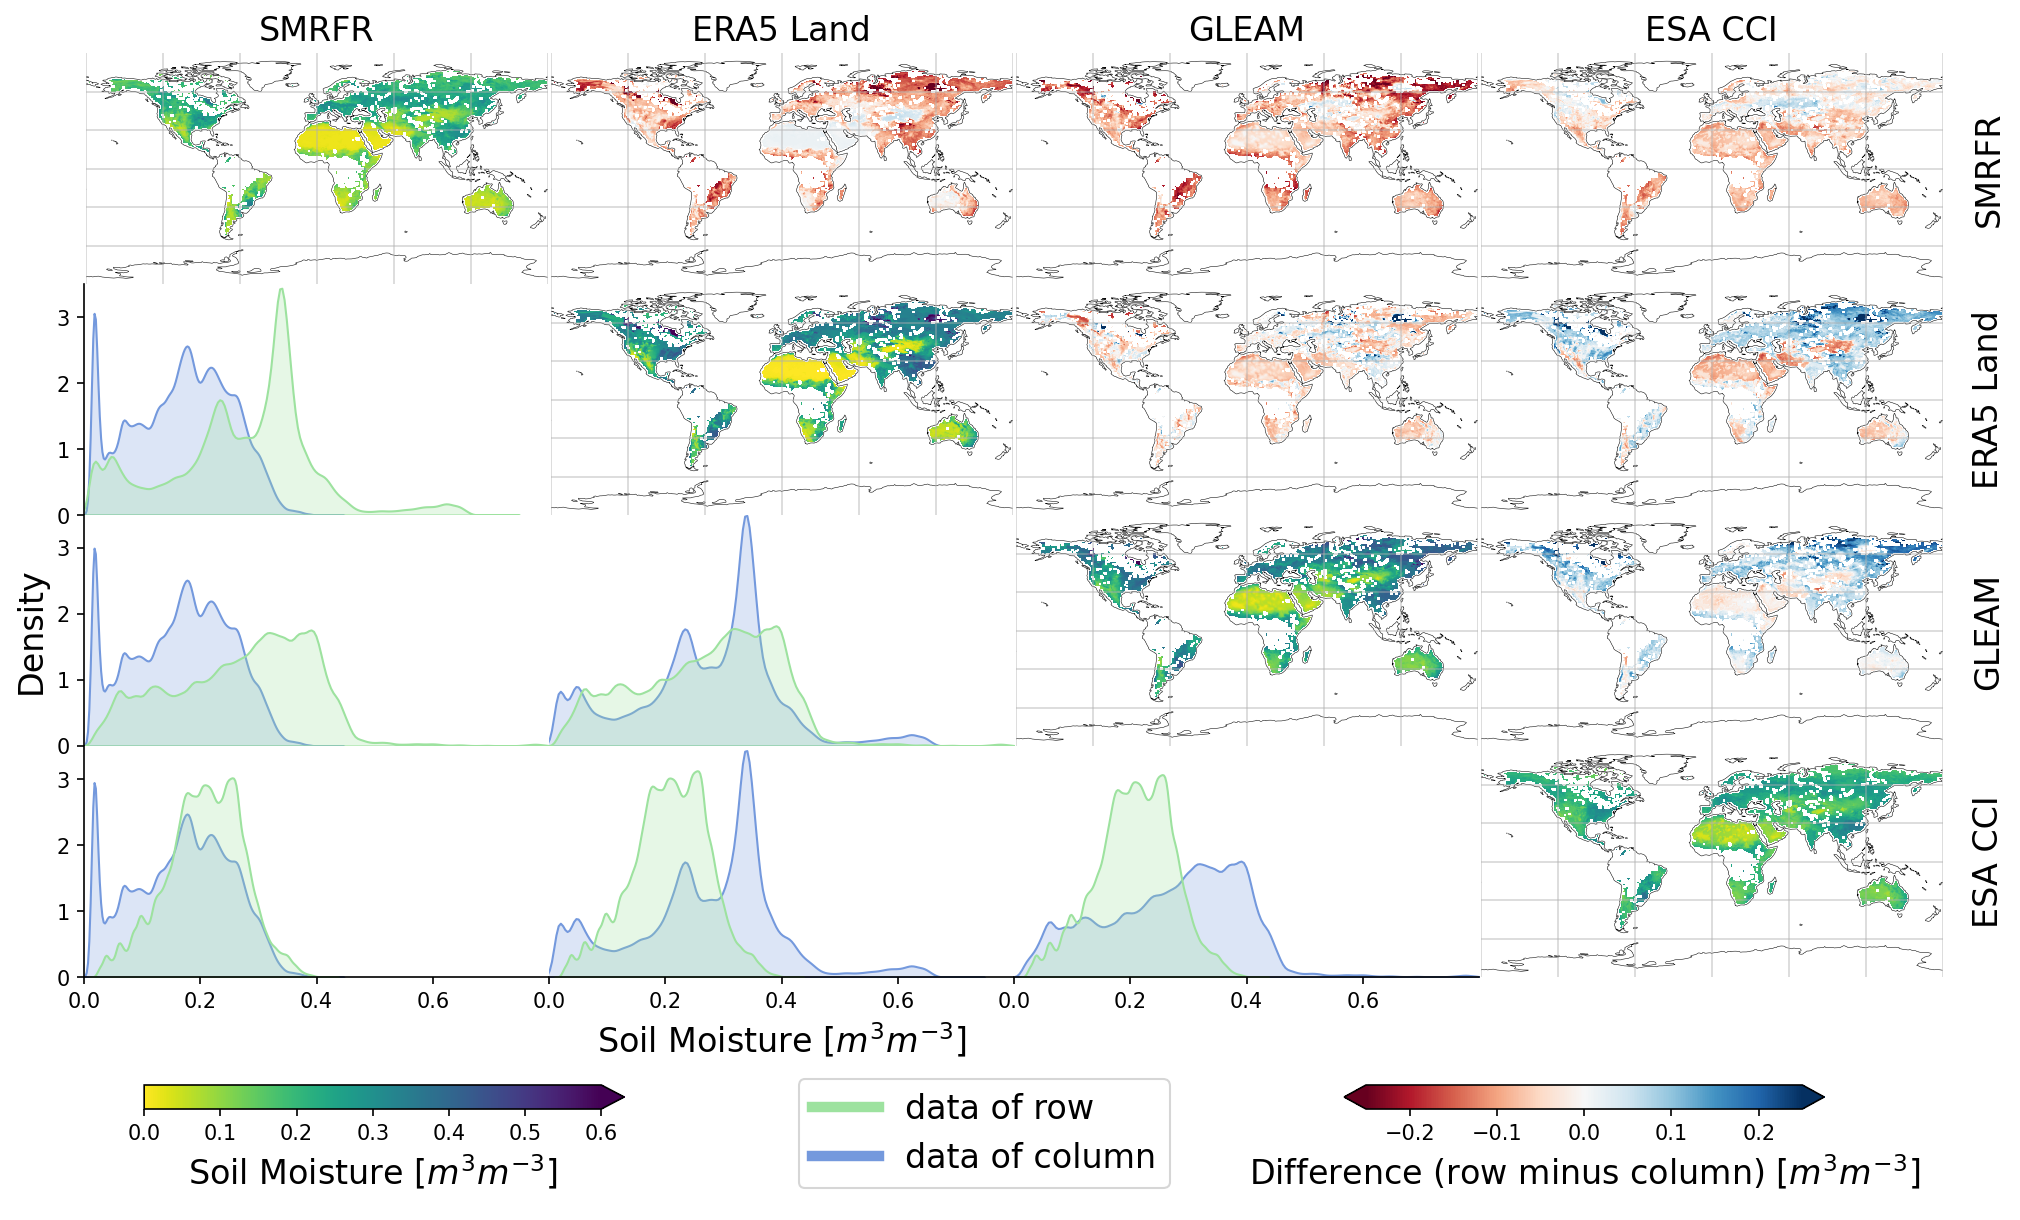

In [3]:
# plot SSM maps
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import warnings 
import numpy as np
import seaborn as sns
from datetime import datetime

t0=datetime.now()
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(16, 8), facecolor='w', edgecolor='k', dpi=150)

fts = 16
data_len = len(ds.data_vars)
data_list = ['SMRFR','ERA5 Land','GLEAM','ESA CCI']
gs = gridspec.GridSpec(data_len, data_len, figure=fig, wspace=0.0,hspace=0)
proj=ccrs.PlateCarree()
extent = [-180, 180, -90, 90]

for nrow in range(data_len):
    for ncol in range(data_len):
        if nrow == ncol:
            im1 = []
            ax = fig.add_subplot(gs[nrow,ncol],projection=proj)
            ax.coastlines(linewidth=0.25)
            ax.set_extent([-180,180,-90,90])
            ax.spines['geo'].set_linewidth(.8)
            ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,alpha=0.5)  
            im1.append(ax.imshow(ds[data_list[nrow]].values,
                                 cmap='viridis_r',transform=proj,
                                origin='lower',extent=extent,
                                vmin=0.0,vmax=0.6))
            if nrow == 0:
                ax.set_title(data_list[nrow],fontsize=fts)
            if ncol == 3:
                ax.text(1.1, 0.5, data_list[nrow], rotation='vertical',
                        transform=ax.transAxes,fontsize=fts,
                        va='center', ha='center')
            ax.set_yticks([])
            ax.set_xticks([])
            ax.axis('off')
        elif nrow < ncol:
            im2 = []
            ax = fig.add_subplot(gs[nrow,ncol],projection=proj)
            data_raw = ds[data_list[nrow]].values-ds[data_list[ncol]].values
            ax.coastlines(linewidth=0.25)
            ax.set_extent([-180,180,-90,90])
            ax.spines['geo'].set_linewidth(.8)
            ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,alpha=0.5)  
            im2.append(ax.imshow(data_raw,cmap='RdBu',
                                 vmin=-0.25,vmax=0.25,
                                 origin='lower',extent=extent))#bwr_r,RdBu
            print(f'{data_list[nrow]}-{data_list[ncol]} {nrow}-{ncol}')
            if nrow == 0:
                ax.set_title(data_list[ncol],fontsize=fts)
            if ncol == 3:
                ax.text(1.1, 0.5, data_list[nrow], rotation='vertical',
                        transform=ax.transAxes,fontsize=fts,
                        va='center', ha='center')
            ax.axis('off')
        elif nrow > ncol:
            ax = fig.add_subplot(gs[nrow,ncol])
            print(f'kdeplot {data_list[nrow]}-{data_list[ncol]} {nrow}-{ncol}')
            df1 = pd.DataFrame({'SM':ds[data_list[nrow]].values.reshape(2228*4454),
                               'data':[data_list[nrow]]*2228*4454})
            df2 = pd.DataFrame({'SM':ds[data_list[ncol]].values.reshape(2228*4454),
                               'data':[data_list[ncol]]*2228*4454})
            df = pd.concat([df1,df2])
            df[df['SM']<0.01]=np.nan
            df.dropna(inplace=True)
            sns.kdeplot(data=df,
                       x='SM',
                       hue='data',
                       fill=True,
                       legend=False,
                       palette=['#9de29f','#7499dd'])
            ax.set_xlim(0,0.8)
            ax.set_xticks([0,0.2,0.4,0.6])
            ax.set_xlabel('')
            ax.set_ylim(0,3.5)
            ax.set_yticks([0,1.,2.,3.])
            if nrow == 3 and ncol!=0:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.set_ylabel('')
            elif nrow==1:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                ax.set_ylabel('')
            elif nrow==2 and ncol==0:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                ax.set_ylabel('Density',fontsize=fts)
            elif nrow==2 and ncol==1:
                ax.axis('off')
            else:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_ylabel('')
                # ax.axis('off')
            if nrow==3 and ncol==1:
                ax.set_xlabel('Soil Moisture $[m^3m^{-3}]$',fontsize=fts)
                
cax_left = fig.add_axes([0.15, 0.0, 0.2, 0.02])
cbar_left = fig.colorbar(im1[0], cax=cax_left, location='bottom',
                        extend='max',pad=0.1)
cbar_left.set_label('Soil Moisture $[m^3m^{-3}]$',fontsize=fts)


cax_center = fig.add_axes([0.4, -0.08, 0.2, 0.1])
cax_center.axis('off')
legend_elements = [Line2D([0],[0],linestyle="-", color="#9de29f",lw=5,label='data of row'),
                   Line2D([0],[0],linestyle="-", color="#7499dd",lw=5,label='data of column')]

cax_center.legend(handles=legend_elements,
                  loc="lower center", 
                  prop={'size': 16})


cax_right = fig.add_axes([0.65, 0.0, 0.2, 0.02])
cbar_right = fig.colorbar(im2[0], cax=cax_right,location='bottom',
                         extend='both')
cbar_right.set_label('Difference (row minus column) $[m^3m^{-3}]$',fontsize=fts)
t1=datetime.now()
time_com = (t1-t0).seconds
print(f'{time_com} seconds')

# plt.tight_layout() 
# plt.savefig('../Figures/Figure8.jpg',
#             dpi=600,bbox_inches='tight')
# plt.show()

SMRFR-ERA5 Land 0-1
SMRFR-GLEAM 0-2
kdeplot ERA5 Land-SMRFR 1-0
ERA5 Land-GLEAM 1-2
kdeplot GLEAM-SMRFR 2-0
kdeplot GLEAM-ERA5 Land 2-1
74 seconds


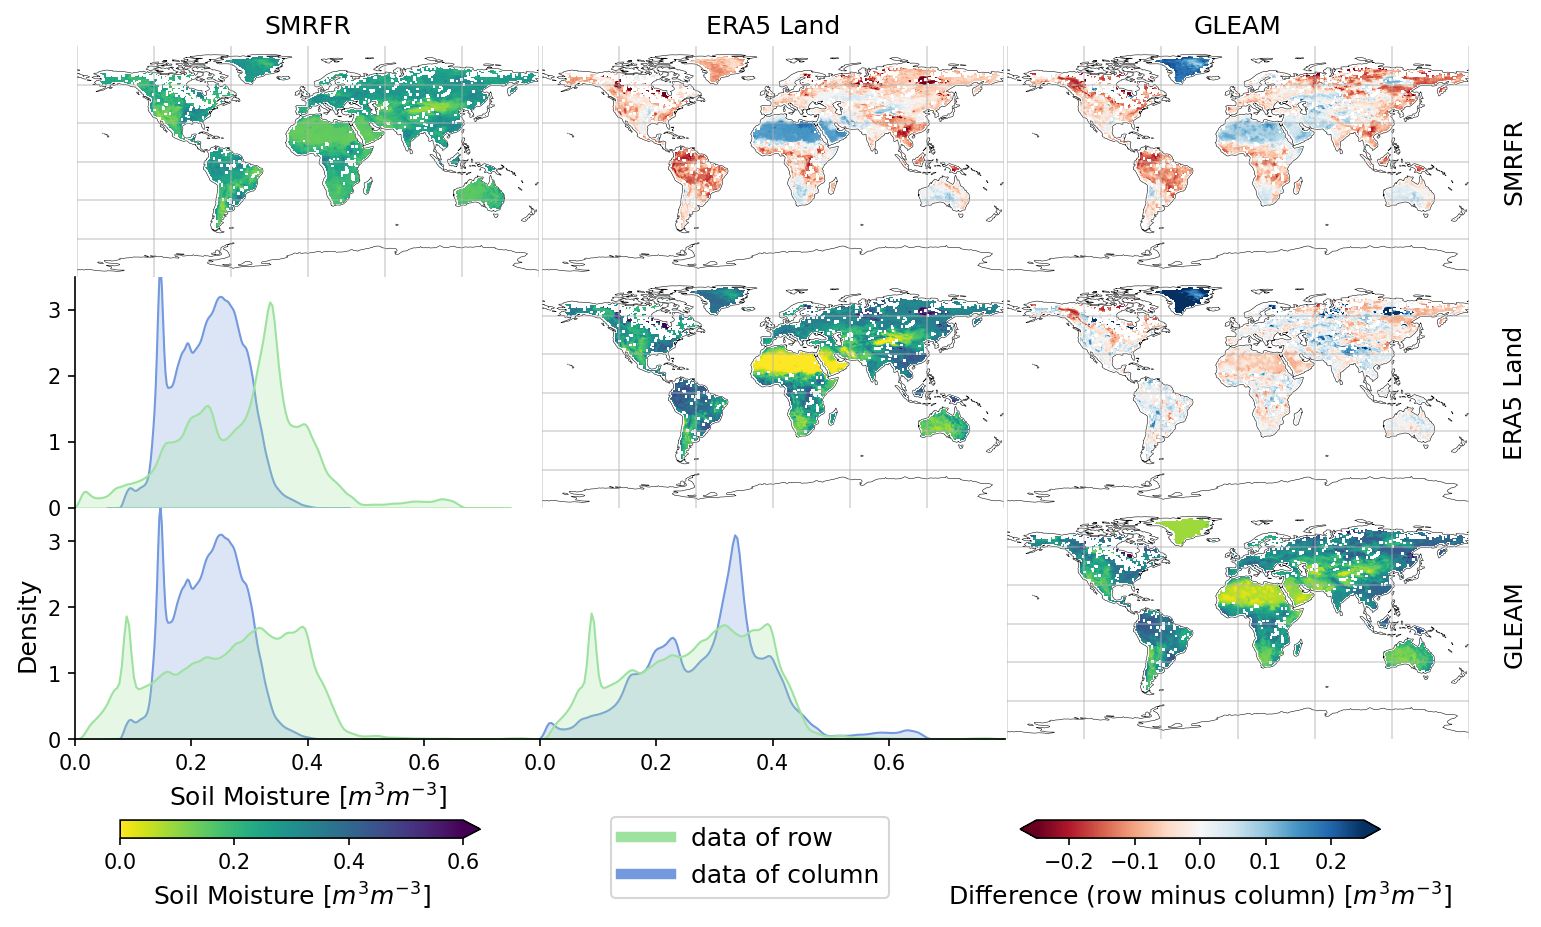

In [6]:
# plot RZSM maps
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import warnings 
import numpy as np
import seaborn as sns
from datetime import datetime

t0=datetime.now()
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(12, 6), facecolor='w', edgecolor='k', dpi=150)



fts = 12
data_len = len(ds.data_vars)
data_list = ['SMRFR','ERA5 Land','GLEAM']
gs = gridspec.GridSpec(data_len, data_len, figure=fig, wspace=0.0,hspace=0)
proj=ccrs.PlateCarree()
extent = [-180, 180, -90, 90]

for nrow in range(data_len):
    for ncol in range(data_len):
        if nrow == ncol:
            im1 = []
            ax = fig.add_subplot(gs[nrow,ncol],projection=proj)
            ax.coastlines(linewidth=0.25)
            ax.set_extent([-180,180,-90,90])
            ax.spines['geo'].set_linewidth(.8)
            ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,alpha=0.5)  
            im1.append(ax.imshow(ds[data_list[nrow]].values,
                                 cmap='viridis_r',transform=proj,
                                origin='lower',extent=extent,
                                vmin=0.0,vmax=0.6))
            if nrow == 0:
                ax.set_title(data_list[nrow],fontsize=fts)
            if ncol == 2:
                ax.text(1.1, 0.5, data_list[nrow], rotation='vertical',
                        transform=ax.transAxes,fontsize=fts,
                        va='center', ha='center')
            ax.set_yticks([])
            ax.set_xticks([])
            ax.axis('off')
        elif nrow < ncol:
            im2 = []
            ax = fig.add_subplot(gs[nrow,ncol],projection=proj)
            data_raw = ds[data_list[nrow]].values-ds[data_list[ncol]].values
            ax.coastlines(linewidth=0.25)
            ax.set_extent([-180,180,-90,90])
            ax.spines['geo'].set_linewidth(.8)
            ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,alpha=0.5)  
            im2.append(ax.imshow(data_raw,cmap='RdBu',
                                 vmin=-0.25,vmax=0.25,
                                 origin='lower',extent=extent))#bwr_r,RdBu
            print(f'{data_list[nrow]}-{data_list[ncol]} {nrow}-{ncol}')
            if nrow == 0:
                ax.set_title(data_list[ncol],fontsize=fts)
            if ncol == 2:
                ax.text(1.1, 0.5, data_list[nrow], rotation='vertical',
                        transform=ax.transAxes,fontsize=fts,
                        va='center', ha='center')
            ax.axis('off')
        elif nrow > ncol:
            ax = fig.add_subplot(gs[nrow,ncol])
            print(f'kdeplot {data_list[nrow]}-{data_list[ncol]} {nrow}-{ncol}')
            df1 = pd.DataFrame({'SM':ds[data_list[nrow]].values.reshape(2228*4454),
                               'data':[data_list[nrow]]*2228*4454})
            df2 = pd.DataFrame({'SM':ds[data_list[ncol]].values.reshape(2228*4454),
                               'data':[data_list[ncol]]*2228*4454})
            df = pd.concat([df1,df2])
            df[df['SM']<0.01]=np.nan
            df.dropna(inplace=True)
            sns.kdeplot(data=df,
                       x='SM',
                       hue='data',
                       fill=True,
                       legend=False,
                       palette=['#9de29f','#7499dd'])
            ax.set_xlim(0,0.8)
            ax.set_xticks([0,0.2,0.4,0.6])
            ax.set_xlabel('')
            ax.set_ylim(0,3.5)
            ax.set_yticks([0,1.,2.,3.])
            if nrow == 2 and ncol!=0:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.set_ylabel('')
            elif nrow==1:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                ax.set_ylabel('')
            elif nrow==2 and ncol==0:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_xlabel('Soil Moisture $[m^3m^{-3}]$',fontsize=fts)
                ax.set_ylabel('Density',fontsize=fts)
                
cax_left = fig.add_axes([0.15, 0.0, 0.2, 0.02])
cbar_left = fig.colorbar(im1[0], cax=cax_left, location='bottom',
                        extend='max',pad=0.1)
cbar_left.set_label('Soil Moisture $[m^3m^{-3}]$',fontsize=fts)


cax_center = fig.add_axes([0.4, -0.08, 0.2, 0.1])
cax_center.axis('off')
legend_elements = [Line2D([0],[0],linestyle="-", color="#9de29f",lw=5,label='data of row'),
                   Line2D([0],[0],linestyle="-", color="#7499dd",lw=5,label='data of column')]

cax_center.legend(handles=legend_elements,
                  loc="lower center", 
                  prop={'size': fts},)


cax_right = fig.add_axes([0.65, 0.0, 0.2, 0.02])
cbar_right = fig.colorbar(im2[0], cax=cax_right,location='bottom',
                         extend='both')
cbar_right.set_label('Difference (row minus column) $[m^3m^{-3}]$',fontsize=fts)
t1=datetime.now()
time_com = (t1-t0).seconds
print(f'{time_com} seconds')

# plt.tight_layout() 
# plt.savefig('../Figures/Figure8.jpg',
#             dpi=600,bbox_inches='tight')
# plt.show()